In [92]:
import mne
# Importing numpy 
import numpy as np
# Importing Scipy 
import scipy as sp
# Importing Pandas Library 
import pandas as pd
# import glob function to scrap files path
from glob import glob
# import display() for better visualitions of DataFrames and arrays
from IPython.display import display
# import pyplot for plotting
import matplotlib.pyplot as plt
import math
from skimage.restoration import denoise_wavelet
from scipy.signal import savgol_filter
from scipy.signal import medfilt
import seaborn as sns
import pywt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [93]:
#band pass filter between 0.5 and 40 hz
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [94]:
from scipy.signal import medfilt # import the median filter function
def median(signal, kernel_size=3):# input: numpy array 1D (one column)
    array=np.array(signal)   
    #applying the median filter
    med_filtered=sp.signal.medfilt(array, kernel_size=kernel_size) # applying the median filter order3(kernel_size=3)
    return  med_filtered # return the med-filtered signal: numpy array 1D

In [95]:
#notch filter apllied at 50hz
def Implement_Notch_Filter(time, band, freq, ripple, order, filter_type, data):
    from scipy.signal import iirfilter
    fs   = 256#1/time
    nyq  = fs/2.0
    low  = freq - band/2.0
    high = freq + band/2.0
    low  = low/nyq
    high = high/nyq
    b, a = iirfilter(order, [low, high], rp=ripple, btype='bandstop',
                     analog=False, ftype=filter_type)
    filtered_data = lfilter(b, a, data)
    return filtered_data

In [96]:
#notch filter apllied at 50hz
def band_reject_Filter(time, band, freq, ripple, order, filter_type, data):
    from scipy.signal import iirfilter
    fs   = 256#1/time
    nyq  = fs/2.0
    low  = freq - band/2.0
    high = freq + band/2.0
    low  = low/nyq
    high = high/nyq
    b, a = iirfilter(order, [low, high], rp=ripple, btype='bandstop',
                     analog=False, ftype=filter_type)
    filtered_data = lfilter(b, a, data)
    return filtered_data

In [97]:
def do_filter(x):
    # fs = 256
    # lowcut = 128 * 0.15
    # highcut = 128 * 0.30
    # x=butter_bandpass_filter(x, lowcut, highcut, fs, order=10)
    # # x=median(x, 5)
    # # x=savgol_filter(x, 11, polyorder=5 ,mode='nearest')

    fs = 256
    lowcut = 20
    highcut = 49
    x=butter_bandpass_filter(x, lowcut, highcut, fs, order=3)
    x=median(x, 5)
    x=savgol_filter(x, 10, polyorder=5 ,mode='nearest')
    return x

In [98]:
label_name = 'eyebrows'
# trial = 10
# raw_df = pd.read_csv(rf'.\raw_data\{label_name}\{label_name}_{trial}.csv').drop(columns=['timestamps', 'Right AUX'])
raw_df = pd.read_csv(r'.\raw_data\filter_test.csv').drop(columns=['timestamps', 'Right AUX'])
raw_df

,TP9,AF7,AF8,TP10
0,0.488,-17.090,-23.438,3.418
1,-11.230,-28.320,-37.109,-4.395
2,-45.898,-29.785,-42.480,-31.250
3,-41.016,-19.043,-32.227,-30.762
4,-19.043,-17.090,-22.461,-1.953
...,...,...,...,...
12857,-85.938,-31.738,-29.785,-72.754
12858,-60.547,-22.461,-27.832,-44.922
12859,-20.508,-14.648,-26.367,-11.230
12860,43.457,-23.926,-30.273,41.992


# Split then filter

In [99]:
# Split then filtered
n_timesteps = 128
data = raw_df.to_numpy()
input_data = []
for i in range(0, data.shape[0] // n_timesteps * n_timesteps, n_timesteps):
    input = data[i:i+n_timesteps].copy()
    for column in range(input.shape[1]):
        x=np.array(input[:, column]) # copie the signal values in 1D numpy array
        # fs = 256
        # lowcut = 20
        # highcut = 49
        # x=butter_bandpass_filter(x, lowcut, highcut, fs, order=3)
        # x=median(x, 5)
        # x=savgol_filter(x, 10, polyorder=5 ,mode='nearest')
        x = do_filter(x)
         
        #x=Implement_Notch_Filter(0.02, 1, 50, 1, 2, 'butter',x)
        # x=denoise_wavelet(x,method='BayesShrink',mode='hard',wavelet='sym5',wavelet_levels=5,rescale_sigma=True)
        input[:, column] = x
    input_data.append(input) 
input_data = np.concatenate(input_data)
# input_data = input_data.transpose(0, 2, 1)
# input_data = input_data[:, :, -128:, np.newaxis]

input_data.shape, data.shape

((12800, 4), (12862, 4))

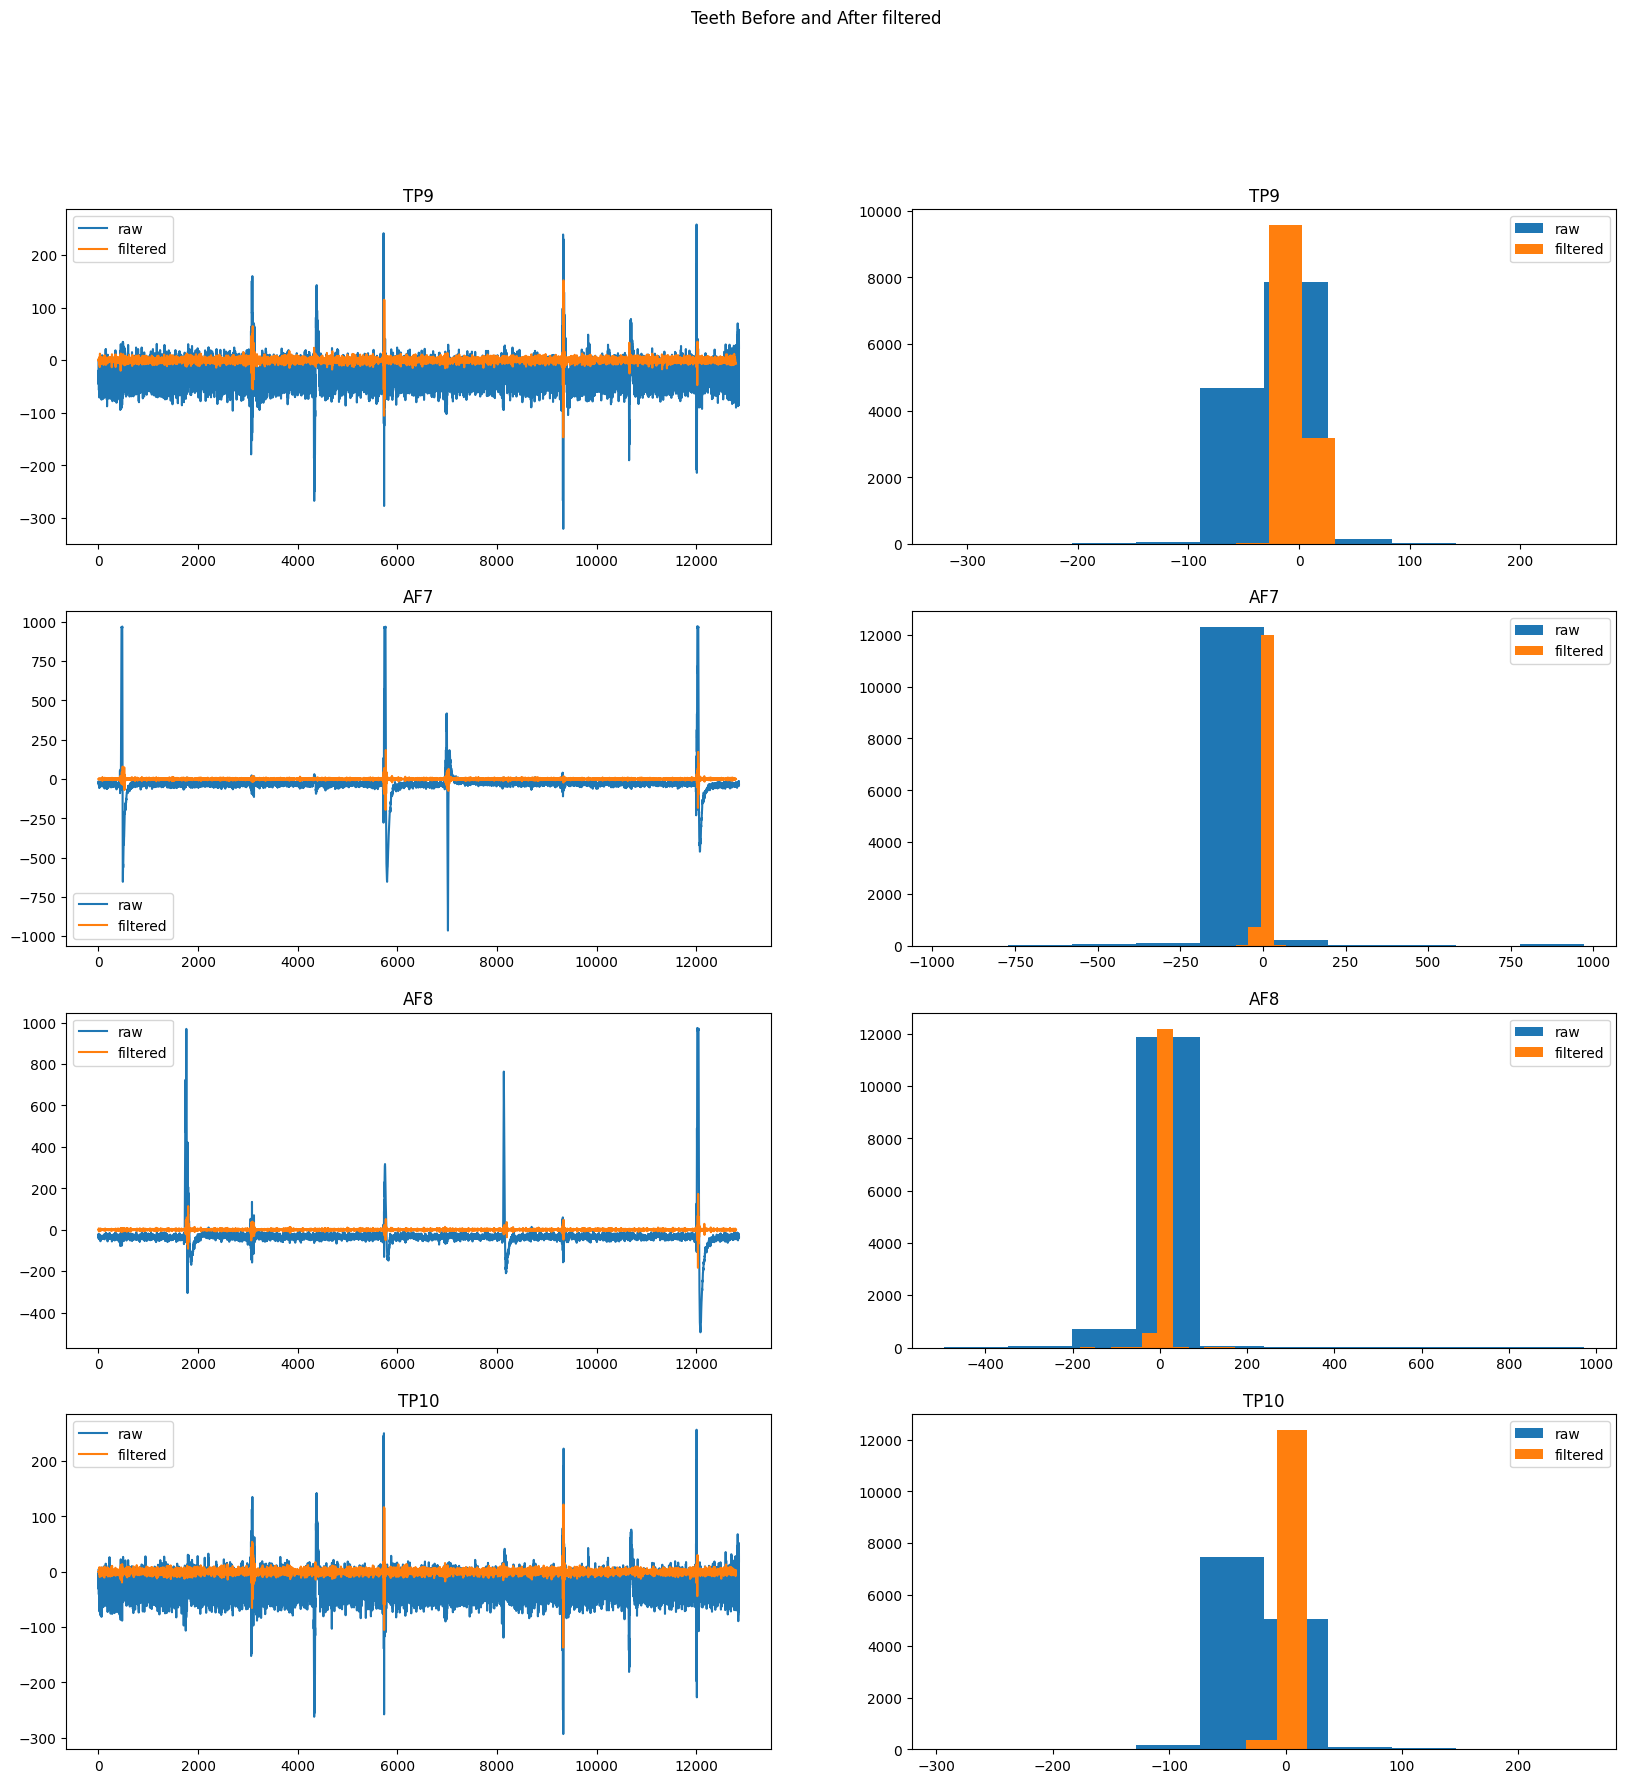

In [100]:
plt.figure(figsize=(20, 20)).suptitle("Teeth Before and After filtered")
plt.subplot(4,2,1)
plt.plot(data[:, 0], label='raw')
plt.plot(input_data[:, 0], label='filtered')
plt.title('TP9')
plt.legend()

plt.subplot(4,2,2)
plt.hist(data[:, 0], label='raw')
plt.hist(input_data[:, 0], label='filtered')
plt.title('TP9')
plt.legend()

plt.subplot(4,2,3)
plt.plot(data[:, 1], label='raw')
plt.plot(input_data[:, 1], label='filtered')
plt.title('AF7')
plt.legend()

plt.subplot(4,2,4)
plt.hist(data[:, 1], label='raw')
plt.hist(input_data[:, 1], label='filtered')
plt.title('AF7')
plt.legend()


plt.subplot(4,2,5)
plt.plot(data[:, 2], label='raw')
plt.plot(input_data[:, 2], label='filtered')
plt.title('AF8')
plt.legend()

plt.subplot(4,2,6)
plt.hist(data[:, 2], label='raw')
plt.hist(input_data[:, 2], label='filtered')
plt.title('AF8')
plt.legend()


plt.subplot(4,2,7)
plt.plot(data[:, 3], label='raw')
plt.plot(input_data[:, 3], label='filtered')
plt.title('TP10')
plt.legend()

plt.subplot(4,2,8)
plt.hist(data[:, 3], label='raw')
plt.hist(input_data[:, 3], label='filtered')
plt.title('TP10')
plt.legend()

# time_sig_df.to_csv('filtered_data/left.csv')

In [101]:
pd.DataFrame(input_data, columns=raw_df.columns).to_csv(rf'.\filtered_data\{label_name}\{label_name}_{trial}.csv')

C:\Users\minhd\AppData\Local\Temp\ipykernel_23080\4211997189.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\minhd\AppData\Local\Temp\ipykernel_23080\4211997189.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\minhd\AppData\Local\Temp\ipykernel_23080\4211997189.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\minhd\AppData\Local\Temp\ipykernel_23080\4211997189.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  p

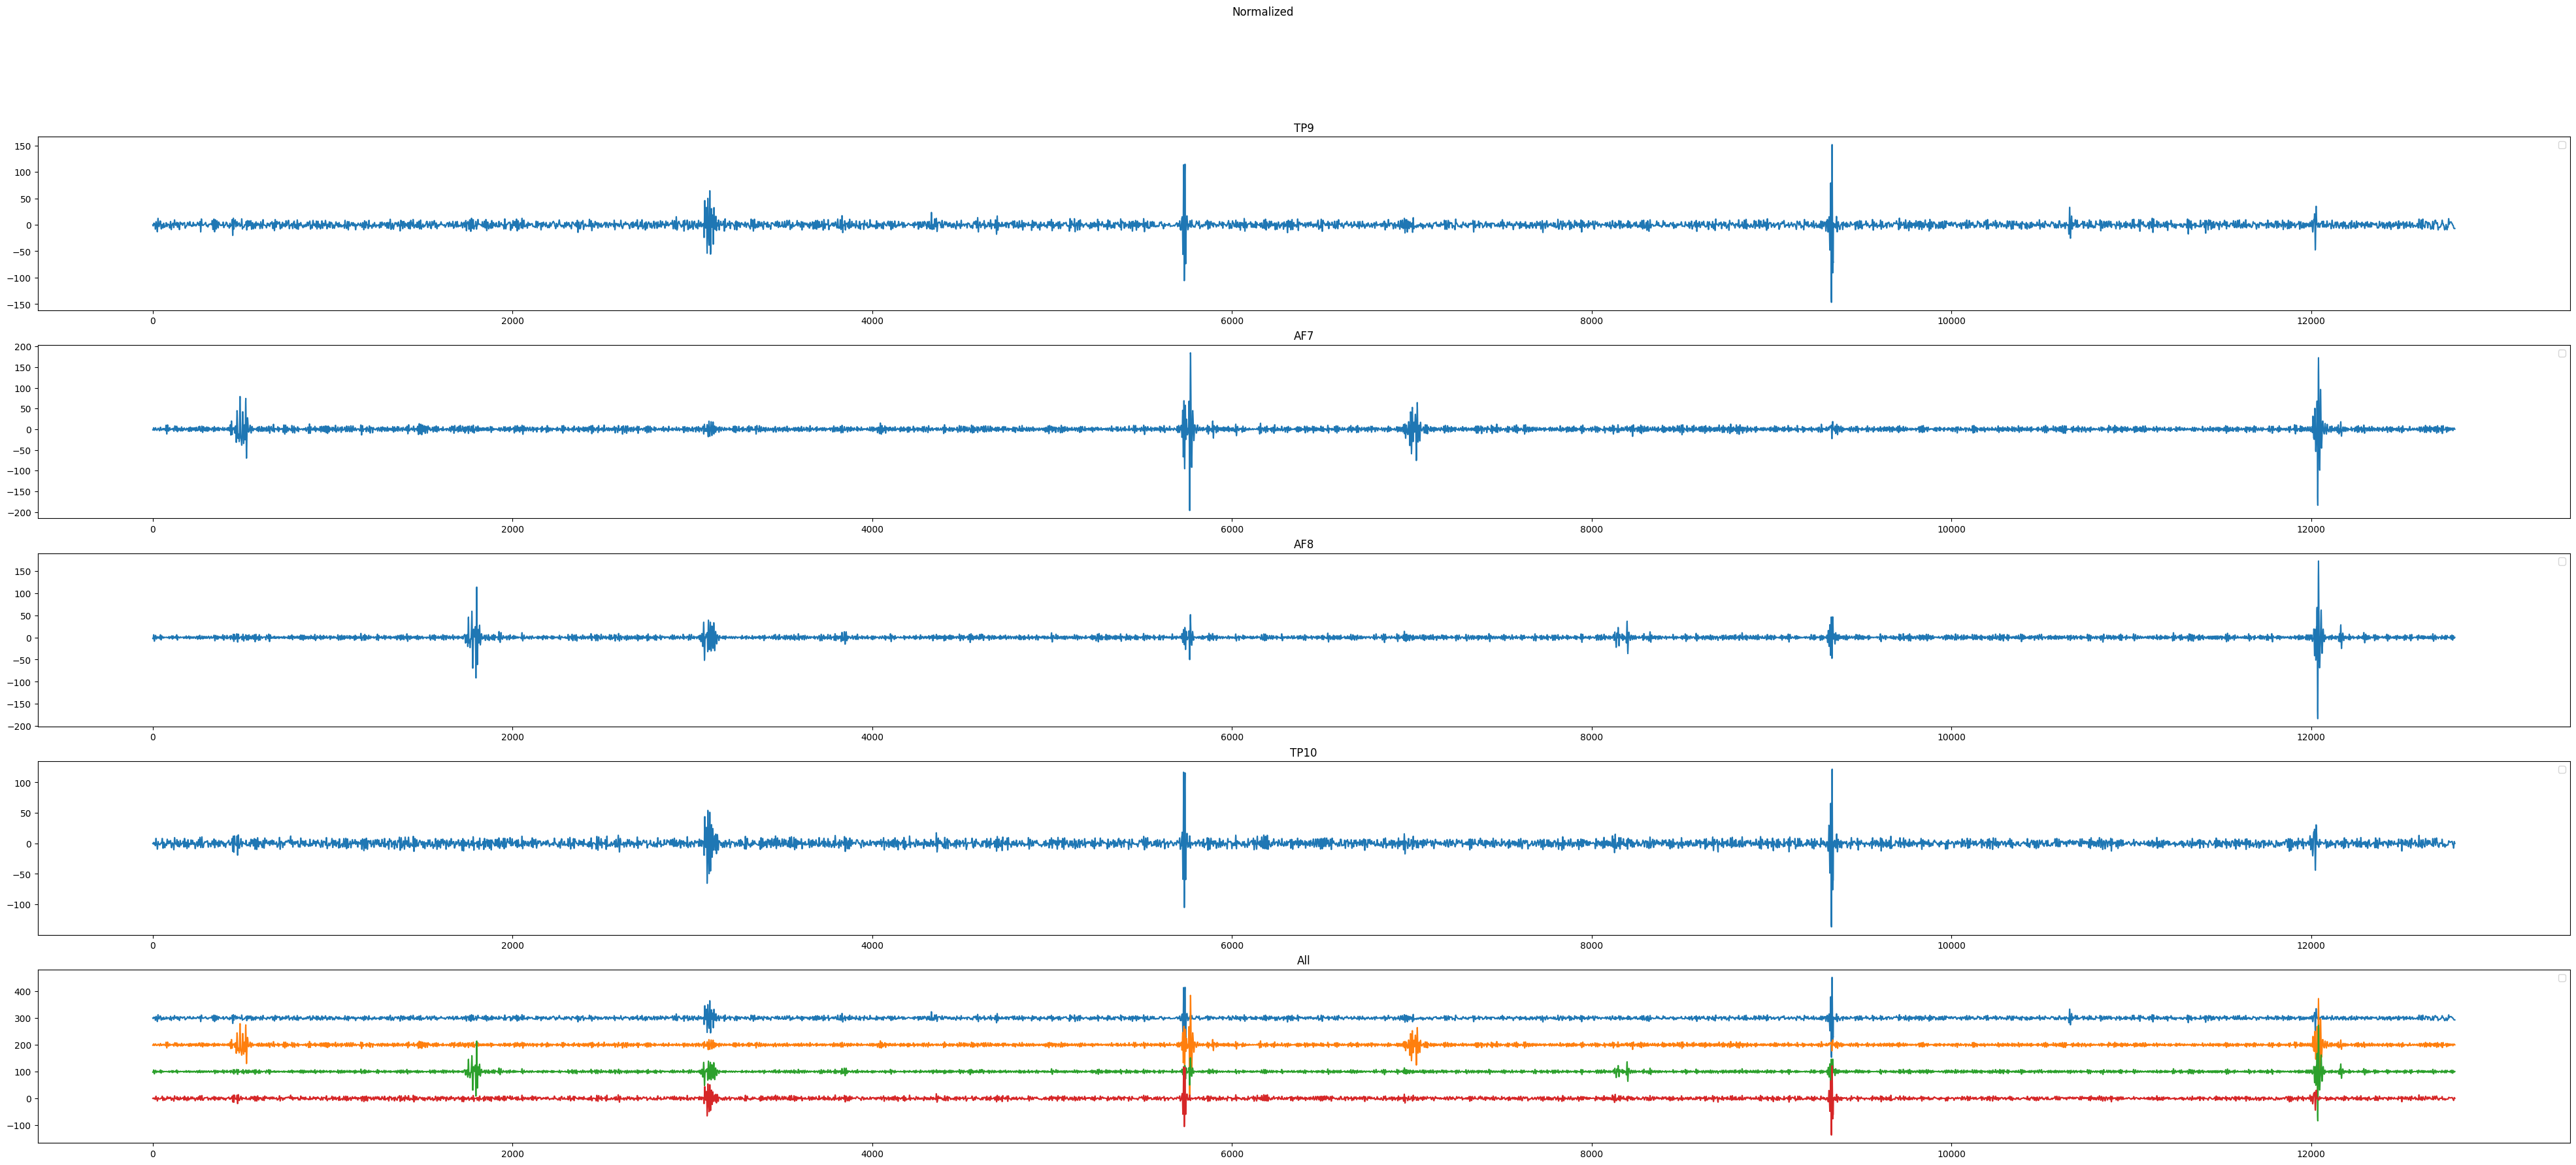

In [102]:
roi = pd.read_csv(rf'roi_v2/{label_name}/{label_name}_{trial}.csv').to_numpy()
# roi = pd.read_csv(rf'.\roi_v2\eyebrows.csv').to_numpy()
where = np.zeros(len(input_data))
for row in roi:
    where[row[0]:row[1]] = row[2]

plt.figure(figsize=(50, 20), dpi=None).suptitle("Normalized")
plt.subplot(5,1,1)
plt.plot(input_data[:, 0])
# plt.fill_between(
#     list(range(input_data.shape[0])), 
#     input_data.min(), 
#     input_data.max(),
#     where=where, alpha=0.8, color='thistle'
# )
plt.title('TP9')
plt.legend()

plt.subplot(5,1,2)
plt.plot(input_data[:, 1])
# plt.fill_between(
#     list(range(input_data.shape[0])), 
#     input_data.min(), 
#     input_data.max(),
#     where=where, alpha=0.8, color='thistle'
# )
plt.title('AF7')
plt.legend()

plt.subplot(5,1,3)
plt.plot(input_data[:, 2])
# plt.fill_between(
#     list(range(input_data.shape[0])), 
#     input_data.min(), 
#     input_data.max(),
#     where=where, alpha=0.8, color='thistle'
# )
plt.title('AF8')
plt.legend()

plt.subplot(5,1,4)
plt.plot(input_data[:, 3])
# plt.fill_between(
#     list(range(input_data.shape[0])), 
#     input_data.min(), 
#     input_data.max(),
#     where=where, alpha=0.8, color='thistle'
# )
plt.title('TP10')
plt.legend()

plt.subplot(5,1,5)
plt.plot(input_data + [300, 200, 100, 0])
# plt.fill_between(
#     list(range(input_data.shape[0])), 
#     -100, #input_data.min(), 
#     400, #input_data.max(),
#     where=where, alpha=0.8, color='thistle'
# )
plt.title('All')
plt.legend()